In [2]:
import os
import pickle
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import interp1d

In [ ]:
def read_data(data_dir):
    data = {}
    for prefix in ['activations', 'errors', 'weights', 'gradients']:
        file_path = os.path.join(data_dir, f'{prefix}.pkl')

        if os.path.exists(file_path):
            with open(file_path, 'rb') as file:
                data[prefix] = pickle.load(file)
                print(f"Loaded {prefix} successfully.")
        else:
            print(f"File for {prefix} not found.")
    return data

In [ ]:
# Flatten the activation, weights, and activations gradients into a single array
train_data = read_data('data/squad_train/step_1000')
activation_array = np.concatenate([tensor.flatten() for tensor in train_data['activations'].values()])
weight_array = np.concatenate([tensor.flatten() for tensor in train_data['weights'].values()])
error_array = np.concatenate([tensor.flatten() for tensor in train_data['errors'].values()])

In [ ]:
def plot_distribution(ax, data, label, xlabel=False):
    exp = np.floor(np.log2(np.abs(data[data != 0]))).astype(int)
    bins = np.linspace(exp.min(), exp.max(), exp.max() - exp.min() + 1)
    counts, bins, patches = ax.hist(exp, bins=bins, density=True, edgecolor='black')

    ax.axvspan(-12, 12, color='grey', alpha=0.3)
    ax.axvspan(-9, 8, color='grey', alpha=0.3)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
    ax.set_xlim(xmin=-60, xmax=15)
    ax.set_yticks(ax.get_yticks()[1:-1])  # Exclude first and last y-tick to prevent overlap
    ax.text(-58, ax.get_ylim()[1] * 0.88, label, fontsize=20)  # Label position

    plt.setp(ax.get_xticklabels(), visible=xlabel)

fig = plt.figure(figsize=(10, 8), dpi=100)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0)
labels = ["activation", "weight", "gradient"]

for i, array in enumerate([activation_array, weight_array, error_array]):
    ax = plt.subplot(gs[i])
    plot_distribution(ax, array, label=labels[i], xlabel=(i == 2))

    if i == 1:
        ax.set_ylabel("Density", fontsize=20, labelpad=10)
    if i == 2:
        ax.set_xlabel("Exponent Value", fontsize=20)

plt.subplots_adjust(left=0.15, top=0.90, bottom=0.10, right=0.95)
plt.savefig('mobilebert_tensors.png', transparent=True, bbox_inches='tight', pad_inches=0.1)


In [ ]:
def extract_layer_and_tensor_name(key):
    # Using regular expression to extract the layer index and tensor name
    match = re.search(r"mobilebert.encoder.layer.(\d+).(.+)", key)
    if match:
        layer_index = int(match.group(1))
        tensor_name = match.group(2)
        return layer_index, tensor_name
    return None, None

def concatenate_tensors(tensor_dict):
    concatenated = {}
    for key, value in tensor_dict.items():
        layer_index, tensor_name = extract_layer_and_tensor_name(key)
        if tensor_name:
            if tensor_name not in concatenated:
                concatenated[tensor_name] = []
            concatenated[tensor_name].append(value)

    # Concatenating tensors for each name
    for tensor_name in concatenated:
        concatenated[tensor_name] = np.concatenate(concatenated[tensor_name])

    return concatenated

inference_data = read_data('data/squad_inference/step_0')
activation_concat = concatenate_tensors(inference_data['activations'])

In [ ]:
# Initialize plot settings
plt.clf()
plt.figure(figsize=(10, 8), dpi=100)

# Constants for labels
fontsize_label, fontsize_ticks = 20, 16

# Plotting each activation distribution
def plot_dist(inputs, label, linewidth=2, num_points=500):
    exp = np.floor(np.log2(np.abs(inputs[inputs != 0]))).astype(int)

    num_bins = exp.max() - exp.min()
    hist, bin_edges = np.histogram(exp, bins=num_bins, density=True)
    bin_edges = bin_edges[1:]

    x = np.linspace(bin_edges.min(), bin_edges.max(), num_points)
    f = interp1d(bin_edges, hist, 'quadratic')

    plt.plot(x, f(x), label=label, linewidth=linewidth)

for k, v in activation_concat.items():
    plot_dist(v, k, linewidth=3)

# Configure plot appearance
plt.xlim(left=-15, right=15)
plt.xlabel('Exponent Value', fontsize=fontsize_label)
plt.ylabel('Density', fontsize=fontsize_label)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)

# Adding shaded regions to the plot
shaded_regions = [(-2, 2), (-4, 4), (-6, 6), (-8, 8)]
shaded_alpha = [0.3, 0.51, 0.657, 0.759]
for region, alpha in zip(shaded_regions, shaded_alpha):
    plt.axvspan(region[0], region[1], color='grey', alpha=0.3)

# Creating and adding legend handles
labels = ['1 bit', '2 bits', '3 bits', '4 bits']
handles = [mpatches.Patch(color='grey', alpha=a, label=l) for a, l in zip(shaded_alpha, labels)]
plt.legend(handles=handles, loc='upper left', fontsize=fontsize_label)

# Save the plot to a file
plt.savefig('mobilebert_activation.png', bbox_inches='tight', transparent=True)


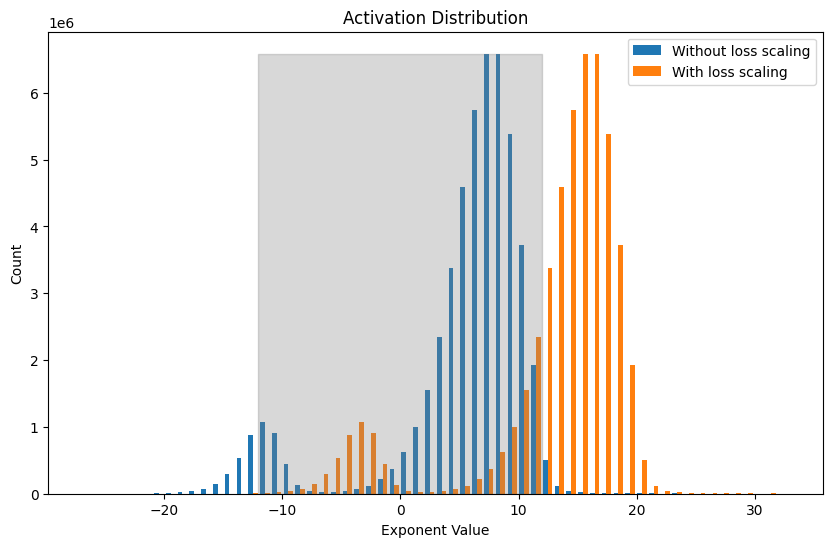

In [7]:
import torch

hist1 = torch.load("error_pre_process.pt").cpu()
hist2 = torch.roll(hist1, 8)

non_empty_bins1 = torch.nonzero(hist1).flatten()
non_empty_bins2 = torch.nonzero(hist2).flatten()

first_non_zero = min(non_empty_bins1[0], non_empty_bins2[0])
last_non_zero = max(non_empty_bins1[-1], non_empty_bins2[-1])

hist1 = hist1[first_non_zero:last_non_zero + 1]
hist2 = hist2[first_non_zero:last_non_zero + 1]

bins = torch.linspace(-126, 127, 255)
bins = bins[first_non_zero:last_non_zero + 2]
bar_width = (bins[1] - bins[0]) * 0.4

plt.figure(figsize=(10, 6))
plt.bar(bins[:-1] - bar_width/2, hist1, width=bar_width, label='Without loss scaling')
plt.bar(bins[:-1] + bar_width/2, hist2, width=bar_width, label='With loss scaling')

plt.fill_betweenx([0, max(max(hist1), max(hist2))], -12, 12, color='gray', alpha=0.3)

plt.title('Activation Distribution')
plt.xlabel('Exponent Value')
plt.ylabel('Count')
plt.legend()

plt.savefig("loss_scaling")